In [ ]:
# --- Heart Disease Prediction with XGBoost ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
import warnings
import joblib
import os

warnings.filterwarnings('ignore')

# Step 1: Load Dataset (Cleveland heart disease dataset - UCI)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df = pd.read_csv(url, names=columns)

# Step 2: Handle missing values (marked as '?')
df = df.replace('?', np.nan)
df = df.dropna()

# Convert all columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

# Convert target: 0 = no disease, 1+ = disease
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Step 3: Features and Labels
X = df.drop('target', axis=1)
y = df['target']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 6: Model + GridSearchCV
params = {
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2]
}
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
gs = GridSearchCV(xgb, params, cv=5, scoring='accuracy')
gs.fit(X_train, y_train)

# Step 7: Evaluation
y_pred = gs.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\n--- Heart Disease XGBoost Results ---")
print(f"Best Parameters: {gs.best_params_}")
print(f"Accuracy: {accuracy*100:.2f}%")
print("Classification Report:\n", report)
print("Confusion Matrix:\n", cm)

# Save model and scaler to Google Drive path
os.makedirs("/content/drive/MyDrive/project/models", exist_ok=True)
joblib.dump(gs.best_estimator_, "/content/drive/MyDrive/project/models/heart_xgboost_model.pkl")
joblib.dump(scaler, "/content/drive/MyDrive/project/models/heart_scaler.pkl")



--- Heart Disease XGBoost Results ---
Best Parameters: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}
Accuracy: 83.33%
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.81      0.85        36
           1       0.75      0.88      0.81        24

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60

Confusion Matrix:
 [[29  7]
 [ 3 21]]


['/content/drive/MyDrive/project/models/heart_scaler.pkl']

In [ ]:
# --- Optimized Heart Disease Prediction with Threshold Tuning ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import joblib
import warnings
import os

warnings.filterwarnings('ignore')

# Step 1: Load Dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
df = pd.read_csv(url, names=columns)

# Step 2: Handle missing values
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)
df = df.apply(pd.to_numeric)

# Step 3: Label adjustment
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

# Step 4: Feature sets
X = df.drop('target', axis=1)
y = df['target']

# Step 5: Preprocessing pipeline
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Step 6: Model pipeline
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# Step 7: Hyperparameter grid
param_grid = {
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 0.1, 0.2],
    'classifier__scale_pos_weight': [1, 2, 3]
}

# Step 8: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 9: Grid search with AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 10: Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- XGBoost Results (Threshold = 0.5) ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob) * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 11: Custom Threshold Tuning
for threshold in [0.4, 0.45, 0.48]:
    print(f"\n--- Custom Threshold ({threshold}) ---")
    y_pred_custom = (y_prob >= threshold).astype(int)
    custom_accuracy = accuracy_score(y_test, y_pred_custom)
    print(f"Custom Accuracy: {custom_accuracy * 100:.2f}%")
    print("Classification Report:\n", classification_report(y_test, y_pred_custom))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))

# Step 12: Save final model
os.makedirs("/content/drive/MyDrive/project/models", exist_ok=True)
joblib.dump(best_model, "/content/drive/MyDrive/project/models/heart_xgboost_model.pkl")


Fitting 5 folds for each of 2304 candidates, totalling 11520 fits

--- XGBoost Results (Threshold = 0.5) ---
Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 6, 'classifier__n_estimators': 50, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8}
Accuracy: 83.33%
ROC AUC Score: 91.29%
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.85        32
           1       0.88      0.75      0.81        28

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60

Confusion Matrix:
 [[29  3]
 [ 7 21]]

--- Custom Threshold (0.4) ---
Custom Accuracy: 88.33%
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89        32
           1       0.86      0.89   

['/content/drive/MyDrive/project/models/heart_xgboost_model.pkl']

In [ ]:
# --- Heart Disease Prediction using All 4 UCI Datasets + Median Imputation + XGBoost ---

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import joblib
import os
import warnings

warnings.filterwarnings('ignore')

# Step 1: Load and merge all 4 datasets from UCI
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

urls = [
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"
]

frames = []
for url in urls:
    df = pd.read_csv(url, names=columns)
    frames.append(df)

df = pd.concat(frames, ignore_index=True)
df = df.replace('?', np.nan)  # ✅ Fixed

# Convert columns to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 2: Impute missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Step 3: Convert target to binary
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(f"✅ Combined Dataset Loaded (after imputation): {df.shape[0]} samples")

# Step 4: Feature and label separation
X = df.drop('target', axis=1)
y = df['target']

# Step 5: Preprocessing
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Step 6: Pipeline with XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb)
])

# Step 7: Hyperparameter grid
param_grid = {
    'classifier__max_depth': [3, 4, 5],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 0.1],
    'classifier__scale_pos_weight': [1, 2]
}

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 9: GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 10: Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- XGBoost Results (Threshold = 0.5) ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob) * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 11: Threshold tuning
for threshold in [0.4, 0.45, 0.48]:
    y_pred_thresh = (y_prob >= threshold).astype(int)
    print(f"\n--- Custom Threshold ({threshold}) ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_thresh) * 100:.2f}%")
    print("Classification Report:\n", classification_report(y_test, y_pred_thresh))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))

# Step 12: Save final model
os.makedirs("/content/drive/MyDrive/project/models", exist_ok=True)
joblib.dump(best_model, "/content/drive/MyDrive/project/models/heart_xgboost_model.pkl")


✅ Combined Dataset Loaded (after imputation): 920 samples
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

--- XGBoost Results (Threshold = 0.5) ---
Best Parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 1, 'classifier__subsample': 0.8}
Accuracy: 84.78%
ROC AUC Score: 92.42%
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.77      0.82        82
           1       0.83      0.91      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184

Confusion Matrix:
 [[63 19]
 [ 9 93]]

--- Custom Threshold (0.4) ---
Accuracy: 84.24%
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.71      

['/content/drive/MyDrive/project/models/heart_xgboost_model.pkl']

In [ ]:
# Final Heart Disease Model: All UCI + SMOTE + Ensemble + Threshold Tuning
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import joblib
import os
import warnings

warnings.filterwarnings('ignore')

# Step 1: Load and combine datasets
columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
           "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
urls = [
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
    "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data"
]
frames = [pd.read_csv(url, names=columns) for url in urls]
df = pd.concat(frames, ignore_index=True).replace('?', np.nan)

# Convert to numeric and impute
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.fillna(df.median(numeric_only=True), inplace=True)
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(f"Dataset shape after merge + clean: {df.shape}")

# Step 2: Features & labels
X = df.drop('target', axis=1)
y = df['target']

# Step 3: Preprocessing
numeric_features = ["age", "trestbps", "chol", "thalach", "oldpeak"]
categorical_features = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 5: Apply SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Step 6: Define base classifiers
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
logreg = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier()

ensemble = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('lr', logreg),
    ('rf', rf)
], voting='soft')

# Step 7: Pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ensemble)
])

# Step 8: Grid search parameters
param_grid = {
    'classifier__xgb__n_estimators': [100, 150, 200],
    'classifier__xgb__max_depth': [3, 4, 5],
    'classifier__xgb__learning_rate': [0.05, 0.1],
    'classifier__xgb__subsample': [0.8, 1.0],
    'classifier__xgb__colsample_bytree': [0.8, 1.0],
    'classifier__xgb__gamma': [0, 0.1],
    'classifier__xgb__scale_pos_weight': [1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)

# Step 9: Evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\n--- Results at Threshold 0.5 ---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 10: Fine-grained threshold tuning
print("\n--- Fine-grained Threshold Sweep ---")
best_acc = 0
best_thresh = 0.5
for thresh in np.arange(0.40, 0.51, 0.01):
    y_pred_thresh = (y_prob >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    if acc > best_acc:
        best_acc = acc
        best_thresh = thresh
    print(f"Threshold {thresh:.2f} → Accuracy: {acc * 100:.2f}%")

print(f"\nBest Threshold: {best_thresh:.2f} with Accuracy: {best_acc * 100:.2f}%")

# Step 11: Save model
os.makedirs("/content/drive/MyDrive/project/models", exist_ok=True)
joblib.dump(best_model, "/content/drive/MyDrive/project/models/heart_xgboost_ensemble_model.pkl")


✅ Dataset shape after merge + clean: (920, 14)
Fitting 5 folds for each of 144 candidates, totalling 720 fits

--- Results at Threshold 0.5 ---
Best Parameters: {'classifier__xgb__colsample_bytree': 1.0, 'classifier__xgb__gamma': 0.1, 'classifier__xgb__learning_rate': 0.1, 'classifier__xgb__max_depth': 3, 'classifier__xgb__n_estimators': 100, 'classifier__xgb__scale_pos_weight': 1, 'classifier__xgb__subsample': 1.0}
Accuracy: 86.41%
ROC AUC Score: 92.43%
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84        82
           1       0.85      0.91      0.88       102

    accuracy                           0.86       184
   macro avg       0.87      0.86      0.86       184
weighted avg       0.87      0.86      0.86       184

Confusion Matrix:
 [[66 16]
 [ 9 93]]

--- Fine-grained Threshold Sweep ---
Threshold 0.40 → Accuracy: 83.70%
Threshold 0.41 → Accuracy: 85.33%
Threshold 0.42 → Accuracy: 85.33%
Threshold 0.

['/content/drive/MyDrive/project/models/heart_xgboost_ensemble_model.pkl']


✅ Evaluation on Holdout Test Set:
Accuracy: 98.75%
ROC AUC: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       1.00      0.98      0.99        50

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



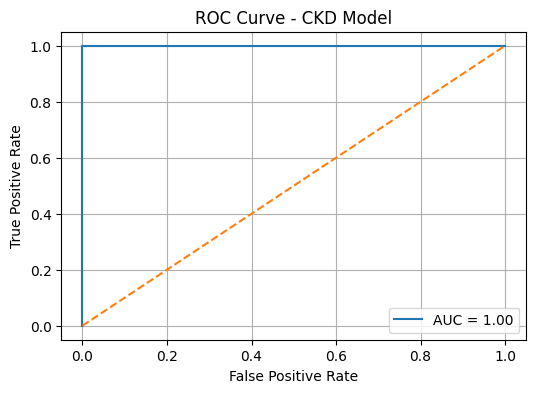


✅ Cross-Validation AUC Scores: [1. 1. 1. 1. 1.]
Mean AUC: 1.0000 ± 0.0000
✅ Model saved to /content/drive/MyDrive/project/models/ckd_model_honest.pkl


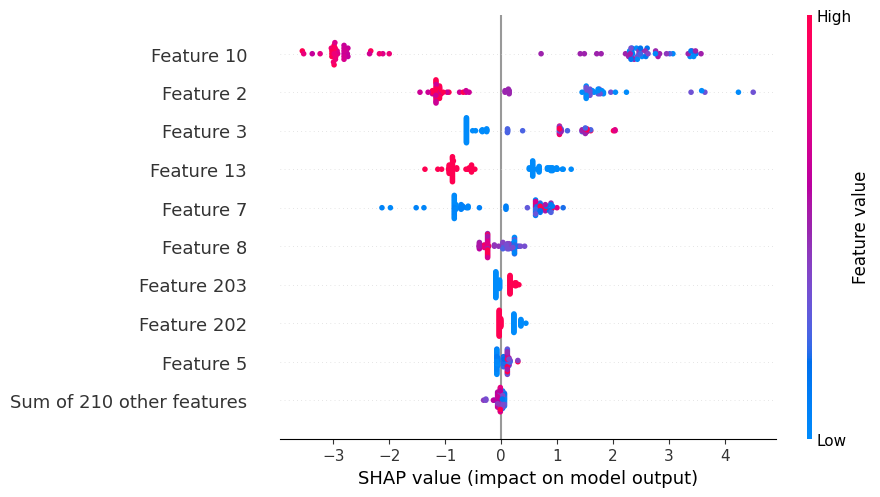

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import shap
import warnings
warnings.filterwarnings("ignore")

# Load and clean dataset
df = pd.read_csv('/content/drive/MyDrive/project/data/kidney_disease/kidney_disease.csv')
if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)

# Normalize string columns
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].astype(str).str.strip().str.lower()

# Encode target
df['classification'] = df['classification'].map({'ckd': 1, 'notckd': 0})
df.dropna(subset=['classification'], inplace=True)

# Features & labels
X = df.drop('classification', axis=1)
y = df['classification']

# Column types
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols)
])

# Full pipeline
model = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\nEvaluation on Holdout Test Set:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob)*100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - CKD Model")
plt.legend()
plt.grid(True)
plt.show()

# Cross-validation AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
print("\nCross-Validation AUC Scores:", np.round(cv_scores, 4))
print(f"Mean AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Save model
joblib.dump(model, '/content/drive/MyDrive/project/models/ckd_model_honest.pkl')
print("Model saved to /content/drive/MyDrive/project/models/ckd_model_honest.pkl")

# Optional: SHAP explainability
explainer = shap.Explainer(model.named_steps["classifier"])
X_transformed = model.named_steps["preprocessor"].transform(X_test)
shap_values = explainer(X_transformed)
shap.plots.beeswarm(shap_values, max_display=10)


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib

# Load Data
image_dir = "/content/drive/MyDrive/project/data/retinopathy/B.%20Disease%20Grading/B. Disease Grading/1. Original Images/a. Training Set"
label_path = "/content/drive/MyDrive/project/data/retinopathy/B.%20Disease%20Grading/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(label_path)
df = df[['Image name', 'Retinopathy grade']]
df.columns = ['filename', 'grade']
df['filename'] = df['filename'].astype(str) + ".jpg"
df['label'] = df['grade'].apply(lambda x: 0 if x == 0 else 1)

# Load Images
IMG_SIZE = 224
images, labels = [], []

for _, row in df.iterrows():
    path = os.path.join(image_dir, row['filename'])
    if os.path.exists(path):
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img)
        img = preprocess_input(img)
        images.append(img)
        labels.append(row['label'])

X = np.array(images)
y = np.array(labels)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Data Augmentation
augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

aug_X, aug_y = [], []
for i in range(len(X_train)):
    x = X_train[i].reshape((1, IMG_SIZE, IMG_SIZE, 3))
    label = y_train[i]
    for _ in range(2):
        aug = augmentor.flow(x, batch_size=1)
        aug_img = next(aug)[0]
        aug_X.append(aug_img)
        aug_y.append(label)

X_train = np.concatenate([X_train, np.array(aug_X)])
y_train = np.concatenate([y_train, np.array(aug_y)])

# VGG16 Feature Extraction
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
feature_extractor = Model(inputs=vgg.input, outputs=vgg.output)

def extract_features(X):
    features = feature_extractor.predict(X, batch_size=16, verbose=1)
    return features.reshape(features.shape[0], -1)

X_train_feat = extract_features(X_train)
X_test_feat = extract_features(X_test)

# Standardize Features
scaler = StandardScaler()
X_train_feat = scaler.fit_transform(X_train_feat)
X_test_feat = scaler.transform(X_test_feat)

# Train Classifiers
svm = SVC(probability=True, kernel='rbf', class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)

svm.fit(X_train_feat, y_train)
rf.fit(X_train_feat, y_train)

# Score-Level Fusion
svm_probs = svm.predict_proba(X_test_feat)[:, 1]
rf_probs = rf.predict_proba(X_test_feat)[:, 1]

# Final fusion by averaging
final_probs = (svm_probs + rf_probs) / 2
final_preds = (final_probs >= 0.5).astype(int)

# Evaluate
print("\n Hybrid Model (VGG16 + SVM + RF) ")
print(f"Accuracy: {accuracy_score(y_test, final_preds) * 100:.2f}%")
print(f"ROC AUC Score: {roc_auc_score(y_test, final_probs) * 100:.2f}%")
print("Confusion Matrix:\n", confusion_matrix(y_test, final_preds))
print("Classification Report:\n", classification_report(y_test, final_preds))

# Save Models
model_dir = "/content/drive/MyDrive/project/models"
os.makedirs(model_dir, exist_ok=True)

joblib.dump(svm, os.path.join(model_dir, "retinopathy_vgg16_svm.pkl"))
joblib.dump(rf, os.path.join(model_dir, "retinopathy_vgg16_rf.pkl"))
joblib.dump(scaler, os.path.join(model_dir, "retinopathy_vgg16_scaler.pkl"))

print("Hybrid model components saved as:")
print("- retinopathy_vgg16_svm.pkl")
print("- retinopathy_vgg16_rf.pkl")
print("- retinopathy_vgg16_scaler.pkl")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 553s 9s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 7s/step

--- Hybrid Model (VGG16 + SVM + RF) ---
Accuracy: 85.54%
ROC AUC Score: 93.12%
Confusion Matrix:
 [[21  6]
 [ 6 50]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78        27
           1       0.89      0.89      0.89        56

    accuracy                           0.86        83
   macro avg       0.84      0.84      0.84        83
weighted avg       0.86      0.86      0.86        83

✅ Hybrid model components saved as:
- retinopathy_vgg16_svm.pkl
- retinopathy_vgg16_rf.pkl
- retinopathy_vgg16_scaler.pkl


In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# === Paths ===
base_path = "/content/drive/MyDrive/project/data/chest_xray/archive (2)/chest_xray"
train_dir = os.path.join(base_path, "train")
test_dir = os.path.join(base_path, "test")
model_path = "/content/drive/MyDrive/project/models/pneumonia_mobilenet_balanced.h5"

# === Parameters ===
IMG_SIZE = 224
BATCH_SIZE = 32

# === Augmentation for training ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# === Compute class weights ===
y_train = train_gen.classes
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = {i : class_weights[i] for i in range(2)}
print("Class weights:", class_weights)

# === Build model ===
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False  # Fine-tune later if needed

inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True)
]

# === Train ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks
)

# === Evaluate ===
print("Evaluating on test set...")
model.load_weights(model_path)
test_preds = (model.predict(test_gen) > 0.5).astype(int).flatten()
y_true = test_gen.classes

# === Report ===
print("\nClassification Report:")
print(classification_report(y_true, test_preds, target_names=["Normal", "Pneumonia"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, test_preds))


Found 4785 images belonging to 2 classes.
Found 531 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✅ Class weights: {0: np.float64(1.9482899022801303), 1: np.float64(0.6726173741917346)}
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8146 - auc: 0.8929 - loss: 0.3944

150/150 ━━━━━━━━━━━━━━━━━━━━ 614s 4s/step - accuracy: 0.8150 - auc: 0.8932 - loss: 0.3937 - val_accuracy: 0.9190 - val_auc: 0.9842 - val_loss: 0.1818
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 711ms/step - accuracy: 0.9167 - auc: 0.9747 - loss: 0.2015

150/150 ━━━━━━━━━━━━━━━━━━━━ 128s 855ms/step - accuracy: 0.9167 - auc: 0.9747 - loss: 0.2015 - val_accuracy: 0.9567 - val_auc: 0.9903 - val_loss: 0.1194
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 122s 816ms/step - accuracy: 0.9234 - auc: 0.9807 - loss: 0.1755 - val_accuracy: 0.9115 - val_auc: 0.9869 - val_loss: 0.2146
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 119s 791ms/step - accuracy: 0.9150 - auc: 0.9796 - loss: 0.1849 - val_accuracy: 0.9416 - val_auc: 0.9925 - val_loss: 0.1254
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 784ms/step - accuracy: 0.9340 - auc: 0.9838 - loss: 0.1529 - val_accuracy: 0.9153 - val_auc: 0.9914 - val_loss: 0.1891
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.9269 - auc: 0.9807 - loss: 0.1740

150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 788ms/step - accuracy: 0.9270 - auc: 0.9807 - loss: 0.1739 - val_accuracy: 0.9492 - val_auc: 0.9919 - val_loss: 0.1167
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.9318 - auc: 0.9832 - loss: 0.1622

150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 789ms/step - accuracy: 0.9318 - auc: 0.9832 - loss: 0.1622 - val_accuracy: 0.9529 - val_auc: 0.9908 - val_loss: 0.1118
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 785ms/step - accuracy: 0.9286 - auc: 0.9814 - loss: 0.1688 - val_accuracy: 0.9473 - val_auc: 0.9940 - val_loss: 0.1346
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.9404 - auc: 0.9842 - loss: 0.1542

150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 788ms/step - accuracy: 0.9403 - auc: 0.9842 - loss: 0.1543 - val_accuracy: 0.9548 - val_auc: 0.9919 - val_loss: 0.1068
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 117s 783ms/step - accuracy: 0.9400 - auc: 0.9865 - loss: 0.1419 - val_accuracy: 0.9341 - val_auc: 0.9944 - val_loss: 0.1329
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 774ms/step - accuracy: 0.9372 - auc: 0.9847 - loss: 0.1546 - val_accuracy: 0.9529 - val_auc: 0.9902 - val_loss: 0.1222
Epoch 12/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 141s 770ms/step - accuracy: 0.9385 - auc: 0.9826 - loss: 0.1579 - val_accuracy: 0.9473 - val_auc: 0.9929 - val_loss: 0.1169
Epoch 13/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 125s 836ms/step - accuracy: 0.9472 - auc: 0.9883 - loss: 0.1348 - val_accuracy: 0.9379 - val_auc: 0.9922 - val_loss: 0.1476
Epoch 14/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 776ms/step - accuracy: 0.9387 - auc: 0.9874 - loss: 0.1441 - val_accuracy: 0.9153 - val_auc: 0.9926 - val_loss: 0.1646
✅ Evaluating on test s